In [1]:
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from utils import *

%matplotlib inline

2023-07-10 15:46:00.600440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:46:04.098060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
folder_path = './points'

x, y = read_data(folder_path)

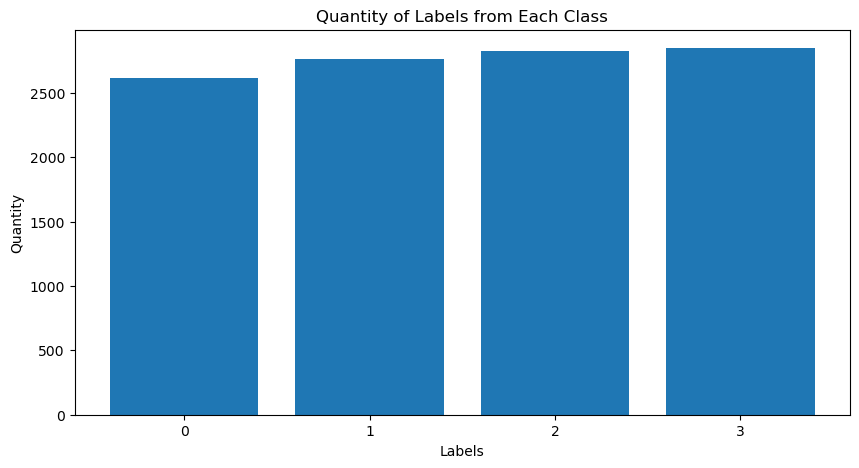

[0 1 2 3]
4


In [4]:
draw_bar_chart(y)

print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

In [5]:
# shuffle
x, y = shuffle(x, y, random_state=0)

# split
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=1/5, random_state=0, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/4, random_state=0, stratify=y_temp, shuffle=True)

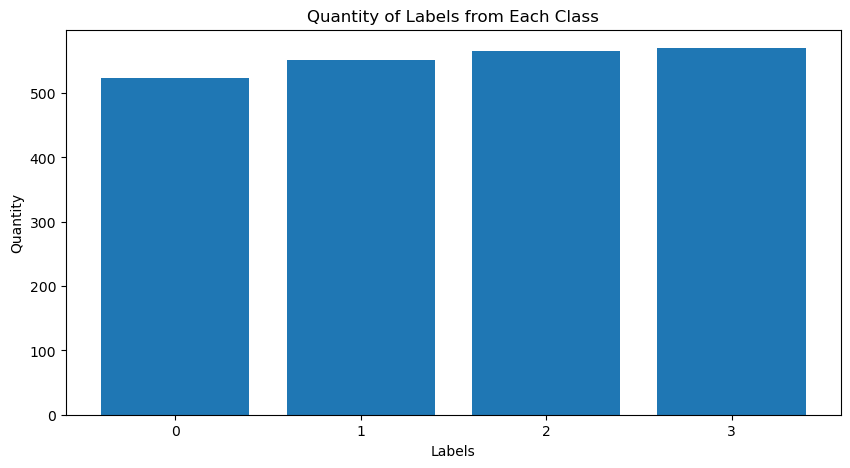

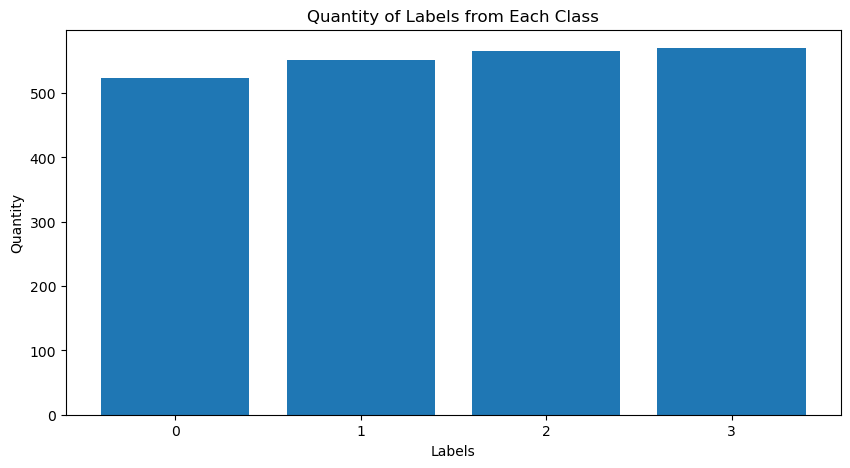

In [6]:
draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.5,
    mlp_dropout=0.5,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.Flatten()(x)

    #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def create_model(input_shape, mlp_dropout=0.1, dropout=0.5, learning_rate=0.0001):
    model = build_model(
        input_shape,
        head_size=32,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=2,
        mlp_units=[128,32],
        mlp_dropout=mlp_dropout,
        dropout=dropout,
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["sparse_categorical_accuracy"]
    )

    return model

In [9]:
input_shape = x.shape[1:]

model = create_model(input_shape)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=10000,
    batch_size=256,
    callbacks=callbacks,
)

model.evaluate(x_val, y_val, verbose=1)

model.evaluate(x_test, y_test, verbose=1)

2023-07-10 15:46:16.609724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 15:46:16.655502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 15:46:16.656122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 21, 3)       6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 21, 3)       1923        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2023-07-10 15:46:22.254566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-10 15:46:22.937448: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4b93c5de00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-10 15:46:22.937474: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-07-10 15:46:22.942583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-10 15:46:23.090048: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 [==============================] - 0s 5ms/step - loss: 1.3688 - sparse_categorical_accuracy: 0.3062


[1.3687760829925537, 0.30619630217552185]

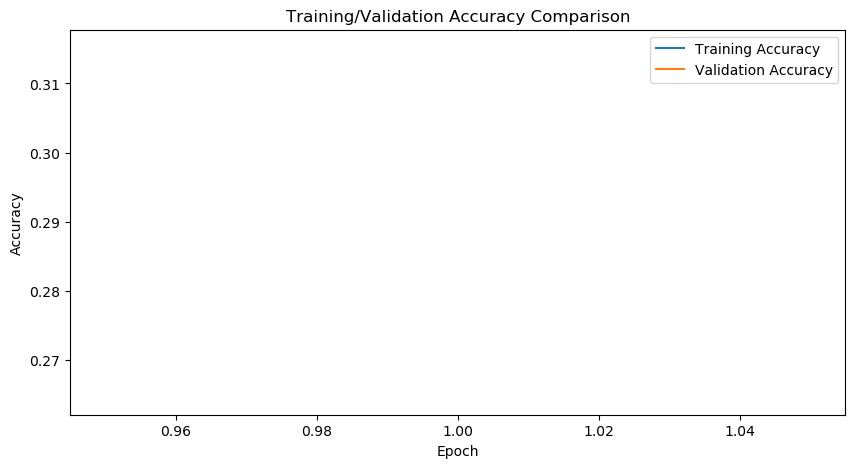

In [10]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

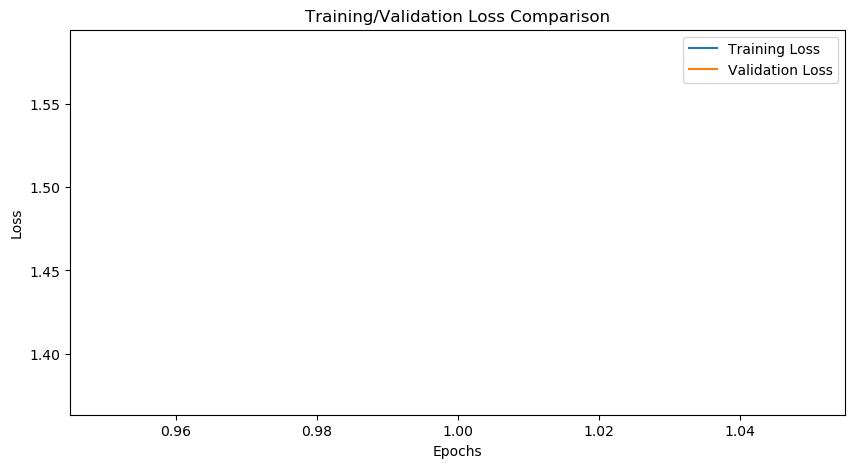

In [11]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

70/70 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       536
           1       0.10      0.38      0.16       148
           2       0.35      0.23      0.28       843
           3       0.40      0.33      0.36       684

    accuracy                           0.31      2211
   macro avg       0.31      0.33      0.29      2211
weighted avg       0.35      0.31      0.32      2211



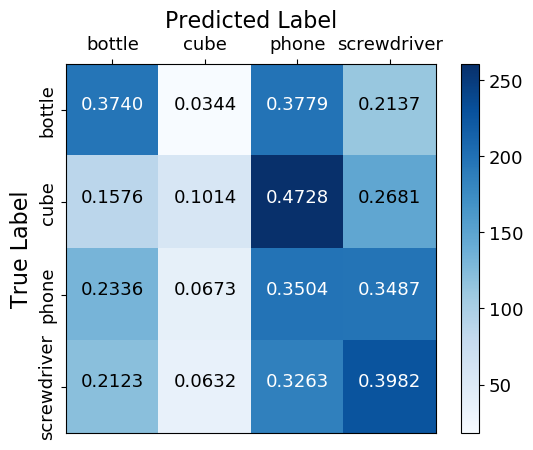

In [12]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_pred,y_test))
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "phone", "screwdriver"])